In [16]:
# 引入库
from jqdata import *
from jqfactor import get_factor_values

# 日常处理
import datetime
import calendar
from dateutil.relativedelta import relativedelta

# 常用库
import numpy as np
import pandas as pd


# 爬虫用
import json
import time
import re
import requests

# 其他
from alphalens.utils import print_table
from tqdm import * # 进度条
import itertools
import copy
import pickle

# 线性模型库
import statsmodels.api as sm

# 计算
import scipy.stats as ss
from scipy.stats import zscore,spearmanr

# 机器学习
from sklearn import linear_model,svm   
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# 画图
from pylab import mpl
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = 'serif'

# 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False

plt.style.use('seaborn')

# 一、择时模型：分类模型 & 条件期望



择时模型主要可分为2类：`分类预测模型`和`条件期望模型`。  

**1. 分类预测模型：**  

+ 预测因子未来收益的`方向`；


+ 用到的`模型`主要有：决策树（随机森林、GBDT等），逻辑回归（Logistic Regression），支持向量机（SVM）等。


**2. 条件期望模型：**

+ 假设因子收益与条件变量服从联合正态分布；

+ 求解因子收益的条件期望和条件协方差；

+ `缺点：`联合正态分布假设难以满足。

# 二、分类模型简介


## 2.1 逻辑回归：操作简单但要求特征分类线性

+  逻辑回归方法使用Sigmoid函数来归一化回归方程中的预测值，使p(x)的取值保持在（0，1）区间内，从而将分类问题映射到回归方程：

### $$P(x_{1})=\frac{e^{w_{0}+w_{1}x_{1}+...+w_{p}x_{p}}}{1+e^{w_{0}+w_{1}x_{1}+...+w_{p}x_{p}}}$$

+ 因此回归方程也可写为：

$$log\left (\frac{P(x)}{1-P(x)} \right )=w_{0}+w_{1}x_{1}+...+w_{p}x_{p}$$

## 2.2 决策树：决策过程直观，应用广泛

决策树是一种基本的分类算法，构建一棵决策树的关键之处在于，每一步选择哪种特征作为节点分裂的规则。其**核心原则**是使得节点分裂后的信息增益最大。

## 2.3 SVM：低维到高维，适合小样本

SVM是一种二类分类模型，对于在低维空间中线性不可分的输入变量，采用核函数将输入变量映射到高维特征空间，在这个高维空间中构造最优分类超平面。

## 2.4 三种分类模型的优缺点对比

**1.逻辑回归：**

+ 优点：可输出预测概率；

+ 缺点：特征变量较多时表现不佳；对于非线性分类问题的处理较困难（依赖于线性变换模型）。

**2.决策树：**

+ 优点：决策过程很直观易理解可以解决非线性分类问题；可以处理特征变量之间的相互关系；

+ 缺点：容易过拟合（可使用随机森林降低过拟概率）。

**3.支持向量机：**

+ 优点：可以处理特征空间较大的分类问题；可以处理特征变量之间的非线性相关性；可以用于训练集较小的情形；

+ 缺点：预测变量过多时运行效率较低；核函数的选择没有统一标准。

# 三、入选因子以及相关系数矩阵
  
从光大Alpha因子体系，即**估值、质量、成长、规模、波动、换手、流动性、动量因子**中挑选如下12个常用因子作为SVM因子择时的测试对象：

|因子类型|因子简称|因子含义| 
|---|---|---|
|估值|book_to_price_ratio|账面市值比| 
|估值|PEG|市盈率相对盈利增长比率| 
|规模|ln(market_cap)|总市值对数| 
|质量|cfo_to_ev|经营活动产生的现金流量净额与企业价值之比TTM|
|成长|total_asset_growth_rate|总资产增长率|
|成长|roe_ttm|权益回报率TTM|
|杠杆|LVGI|财务杠杆指数|
|动量|ROC20|20日变动速率| 
|动量|ROC60|60日变动速率| 
|波动|sharpe_ratio_20|20日夏普比率| 
|流动性|VOL20|20日平均换手率|
|流动性|Volume1M|当前交易量相比过去1个月日均交易量 与过去过去20日日均收益率乘积|
 
**样本筛选规则：**
+ 回测区间：2014年1月1日至2019年12月31日(后期需要用到过去36个月的因子收益均值，所以需将起始时间前推36个月，即推前至2011年1月1日)；  
+ 调仓日：每月最后一个交易日为调仓日，以每月最后一个交易日的收盘价买入卖出；   
+ 股票池：HS300；剔除选股日的ST股票；剔除上市不满6个月的股票；剔除选股日由于停牌等原因而无法买入的股票。   

---

**上述因子的初步筛选方式:**

从大类因子中筛选收益率显著,高IC、IR并且单调性得分高的因子:

单调性得分计算方式:

$$Mono\_Score = \frac{R_5-R_1}{R_4-R_2}$$
注:$R_i$代表分层回溯法得到的第i组的年化收益率

---

<center>***对因子进行打分***</center>

|筛选指标|指标说明|打分标准(绝对值)|
|--|--|--|
|Factor_Ret|最近60个月因子收益均值|>0.002|
|Factor_Ret_tvalue|最近60个月因子收益率t值|>2|
|IC|信息系数|>0.02|
|IR|信息系数比|>0.2|
|Monotony|单调性得分|>2|

## 3.1 数据提取

根据样本筛选规则从jqdata的API接口中提取择时因子的原始数据。

In [2]:
## step1：获取回测区间每月最后一个交易日
def GetTradePerid(start_date: str, end_date: str, freq: str = 'M') -> list:
    '''
    start_date/end_date:str YYYY-MM-DD
    freq:M月末，Q季末,Y年末 默认M
    ================
    return datetime.date list 
    '''
    days = [x.date() for x in pd.date_range(start_date, end_date, freq=freq)]

    return [
        d if d in get_trade_days(start_date, end_date) else get_trade_days(
            end_date=d, count=1)[0] for d in days
    ]


## step2:获取回测区间每月最后一个交易日的满足筛选条件的股票池
def GetStocks(symbol: str, trDate: datetime.date, limit: int = 6) -> list:
    '''
    symobl:指数代码
    trDate:交易日期
    limit:上市不足N月 默认未上市不足6月
    ================
    return list 
    '''
    stocks = get_index_stocks(symbol, date=trDate)

    # 1.过滤ST
    is_st = get_extras('is_st', stocks, end_date=trDate, count=1).iloc[-1]

    stocks = is_st[is_st == False].index.tolist()

    # 2.过滤上市不足6月股票
    stocks = [
        s for s in stocks
        if get_security_info(symbol, date=trDate).start_date < trDate -
        datetime.timedelta(limit * 30)
    ]

    # 3.过滤当日未交易股票
    pause = get_price(
        stocks, end_date=trDate, fields='paused', count=1, panel=False)
    stocks = pause.query('paused==0')['code'].values.tolist()

    return stocks


## step3: 提取因子
def GetFactors(dates: list):

    factors_list = []

    for date in tqdm(dates, desc='Download Factors'):

        ## 提取每月末的股票池
        stocks = GetStocks('000300.XSHG', date)

        ## 提取每月末对应的因子值
        factors = factors = [
            'book_to_price_ratio', 'PEG', 'market_cap', 'cfo_to_ev',
            'total_asset_growth_rate', 'roe_ttm', 'LVGI', 'ROC20', 'ROC60',
            'sharpe_ratio_20', 'VOL20', 'Volume1M'
        ]
        
        f_dict = get_factor_values(
            stocks, factors, end_date=date, count=1)
        
        f_df = pd.concat(f_dict, axis=1).stack()

        ## 提取辅助因子：申万一级行业名称,用于行业中性化
        ind = get_industry(security=stocks, date=date)

        ind = {
            x: v.get('sw_l1').get('industry_name', np.nan)
            for x in ind.keys() for v in ind.values() if 'sw_l1' in v.keys()
        }

        f_df['INDUSTRY'] = list(
            map(lambda x: ind.get(x, np.nan), f_df.index.get_level_values(1)))

        factors_list.append(f_df)  # 将每月末提取的因子数据存list中

    factors_df = pd.concat(factors_list)
    factors_df.index.names = ['date','code']
    return factors_df

In [3]:
## 设置回测区间
start_date = '2014-01-01'
end_date = '2019-12-31'

# 前推36个月
begin_date = pd.date_range(end=start_date,periods=36,freq='M')[0].strftime('%Y-%m-%d')
dates = GetTradePerid(begin_date, end_date, freq='M')

In [12]:
# 数据获取
datas = GetFactors(dates)
datas.to_csv('../Data/SVM.csv')

datas.head()

Download Factors: 100%|██████████| 108/108 [01:52<00:00,  1.30it/s]


LVGI    ...     INDUSTRY
date       code                     ...             
2011-01-31 000001.XSHE  0.999736    ...        金融服务I
           000002.XSHE  0.993440    ...        金融服务I
           000009.XSHE  1.020497    ...        金融服务I
           000012.XSHE  0.906201    ...        金融服务I
           000021.XSHE  1.357714    ...        金融服务I

[5 rows x 13 columns]

## 3.2 数据清洗

对提取的因子原始数据进行数据清洗，包括**异常值处理**、**缺失值处理**、**标准化处理**以及**正交化处理**，各处理过程所使用的方法如下所示：

+ Step1 异常值处理：采用稳健的`绝对中位数法MAD`；
 
 
+ Step2 缺失值处理：由于行业缺失比例很小，如果有缺失，则直接删除行业缺失值；对于择时因子，则用该天的`行业中位数代替`；对于缺失比例很大（如超过20%）的因子则直接删除；


+ Step3 标准化处理：采用`z值标准化`；


+ Step4 正交化处理：采用`对称正交法`，因为用该方法正交后的因子值与原始值的相似程度高于其他正交方法，而且不需要确定正交顺序，计算效率高。

In [17]:
# 数据读取
factors = pd.read_csv('../Data/SVM.csv',index_col=[0,1],parse_dates=True)
factors.head()

LVGI    ...     INDUSTRY
date       code                     ...             
2011-01-31 000001.XSHE  0.999736    ...        金融服务I
           000002.XSHE  0.993440    ...        金融服务I
           000009.XSHE  1.020497    ...        金融服务I
           000012.XSHE  0.906201    ...        金融服务I
           000021.XSHE  1.357714    ...        金融服务I

[5 rows x 13 columns]

In [18]:
## step1:构建绝对中位数处理法函数
# data为输入的数据集，如果数值超过num个判断标准则使其等于num个标准
def extreme_process_MAD(df:pd.DataFrame, num:int=3)->pd.DataFrame:

    # 为不破坏原始数据，先对其进行拷贝
    df_ = df.copy()
    feature_names = [
        i for i in df_.columns.tolist() if i not in ['INDUSTRY']
    ]  #获取数据集中需测试的因子名

    # 获取中位数
    median = df_[feature_names].median(axis=0)

    # 按列索引匹配，并在行中广播
    MAD = abs(df_[feature_names].sub(median, axis=1)).median(axis=0)

    # 利用clip()函数，将因子取值限定在上下限范围内，即用上下限来代替异常值
    df_.loc[:, feature_names] = df_.loc[:, feature_names].clip(
        lower=median - num * 1.4826 * MAD,
        upper=median + num * 1.4826 * MAD,
        axis=1)

    return df_


## step2:构建缺失值处理函数
def factors_null_process(df:pd.DataFrame)->pd.DataFrame:

    # 删除行业缺失值
    df = df[df['INDUSTRY'].notnull()]

    # 变化索引，以行业为第一索引，股票代码为第二索引
    df_ = df.reset_index().set_index(['INDUSTRY', 'code']).sort_index()

    # 用行业中位数填充
    df_ = df_.groupby(
        level=0).apply(lambda factor: factor.fillna(factor.median()))

    # 将索引换回
    df_ = df_.reset_index().set_index('code').sort_index()

    return df_.drop('date', axis=1)


## step3:构建标准化处理函数
def data_scale_Z_Score(df:pd.DataFrame)->pd.DataFrame:
    # 为不破坏原始数据，先对其进行拷贝

    df_ = df.copy()
    feature_names = [
        i for i in df_.columns.tolist() if i not in ['INDUSTRY']
    ]  #获取数据集中需测试的因子名

    df_.loc[:, feature_names] = (
        df_.loc[:, feature_names] -
        df_.loc[:, feature_names].mean()) / df_.loc[:, feature_names].std()

    return df_


## step4:构建对称正交变换函数
def lowdin_orthogonal(df:pd.DataFrame)->pd.DataFrame:

    df_ = df.copy()
    # 除去第一列行业指标,将数据框转化为矩阵
    col = [i for i in df_.columns.tolist() if i not in ['INDUSTRY']]
    F = np.array(df_[col])
    M = np.dot(F.T, F)
    a, U = np.linalg.eig(M)  #U为特征向量，a为特征值
    one = np.identity(len(col))
    D = one * a  #生成有特征值组成的对角矩阵
    D_inv = np.linalg.inv(D)
    S = U.dot(np.sqrt(D_inv)).dot(U.T)
    df_[col] = df_[col].dot(S)
    return df_

In [19]:
factors1 = factors.groupby(level='date').apply(extreme_process_MAD)  #去极值
factors2 = factors1.groupby(level='date').apply(factors_null_process)  #去缺失值
factors3 = factors2.groupby(level='date').apply(data_scale_Z_Score)  #标准化处理
factors4 = factors3.groupby(level='date').apply(lowdin_orthogonal)  #对称正交化

In [20]:
print(factors.info())
print('去缺失值:\n%s'%factors2.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31286 entries, (2011-01-31 00:00:00, 000001.XSHE) to (2019-12-31 00:00:00, 603993.XSHG)
Data columns (total 13 columns):
LVGI                       30203 non-null float64
PEG                        19212 non-null float64
ROC20                      31286 non-null float64
ROC60                      31286 non-null float64
VOL20                      31286 non-null float64
Volume1M                   31286 non-null float64
book_to_price_ratio        31286 non-null float64
cfo_to_ev                  30309 non-null float64
market_cap                 31286 non-null float64
roe_ttm                    31268 non-null float64
sharpe_ratio_20            31282 non-null float64
total_asset_growth_rate    30632 non-null float64
INDUSTRY                   31286 non-null object
dtypes: float64(12), object(1)
memory usage: 4.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31286 entries, (2011-01-31 00:00:00, 000001.XSHE) to (2019-12-31 00:00:0

# 四、以对称正交后的因子收益作为预测目标变量

因子择时是通过对预期有效的因子赋予较大的权重，对预期失效的因子赋予较小的权重或剔除来实现因子权重的动态配置，进而提高组合收益，所以因子有效性衡量指标的选择显得尤为重要。IC、IR、因子收益等指标都可用来衡量因子的有效性，但由于因子IC是秩相关系数，找到影响相关系数的解释变量比较困难，而因子收益可以类比股票多空组合的收益，从中筛选出有效的解释变量的可能性更大，所以我们**采用因子收益（即因子横截面回归的斜率）来衡量因子有效性**。但回归之前需要对因子进行对称正交处理，对称正交后的截面因子值两两正交，**这保证了回归法计算各个因子收益时，因子间不会出现重复暴露某一风格的情况，从而回归得到的因子收益更具有代表性，也更适合作为分类预测模型的目标变量**
 
## 4.1 对称正交前后因子横截面相关系数对比

In [23]:
# 构建计算横截面因子载荷相关系数均值函数
def get_relations(datas: pd.DataFrame)->pd.DataFrame:
    '''
    datas:MultiIndex date,code columns->factor_name
    '''
    dates = set(datas.index.get_level_values(0))
    
    relations = 0
    
    for date,data in datas.groupby(level='date'):

        # data为提取横截面因子数据
        relations = relations + data.corr()  # 计算相关系数
        
    return relations / len(dates)  # relations_mean计算横截面因子载荷相关系数均值


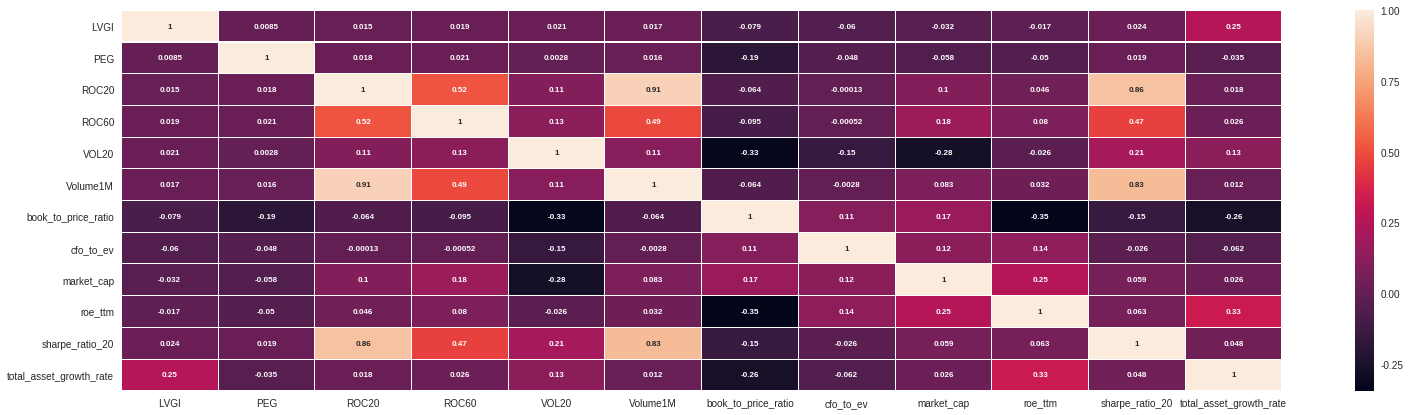

In [24]:
#绘制因子正交前的相关性的热力图
fig = plt.figure(figsize=(26, 7))
relations = get_relations(factors3)  #计算对称正交之前的相关系数矩阵

sns.heatmap(
    relations,
    annot=True,
    linewidths=0.05,
    linecolor='white',
    annot_kws={
        'size': 8,
        'weight': 'bold'
    })

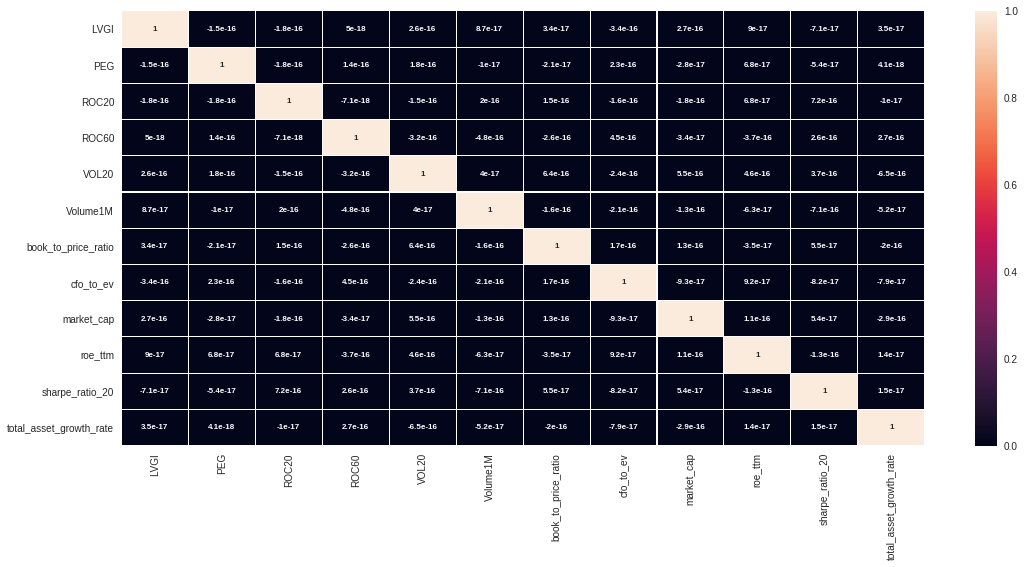

In [25]:
# 绘制因子正交后的相关性热力图
fig = plt.figure(figsize=(18, 8))
relations = get_relations(factors4)  #计算对称正交之后的相关系数矩阵

sns.heatmap(
    relations,
    annot=True,
    linewidths=0.05,
    linecolor='white',
    annot_kws={
        'size': 8,
        'weight': 'bold'
    })

从原始的横截面因子载荷(去极值中性化后)相关系数矩阵热力图中可以看出，有些因子之间的共线性确实较为明显；但将因子对称正交后，横截面因子载荷的相关性基本降低为0，共线性已基本消除。

## 4.2 计算对称正交后的因子收益

采用`截面回归`的方法计算因子收益，在对每个因子进行回归时需要加入申万一级行业虚拟变量和市值因子剔除行业因素和市值因素，但计算规模因子（对数市值）时只剔除行业。

In [11]:
# 提取市值因子并计算未来一期对数收益率
def GetRetCap(factors: pd.DataFrame) -> pd.DataFrame:
    '''
    factors:因子值的df MultiIndex date,code
    ==================
    return df next_ret,market_cap
    '''
    
    dates = [x.date() for x in factors.index.levels[0]]
    start_date = min(dates)
    end_date = max(dates)
    
    # 将最后一天的日期再往后推30天，这样能将最后一个调仓日往后推一个月
    target = end_date + relativedelta(months=1)
    monthCountDay = calendar.monthrange(target.year, target.month)[1]
    offset_day = datetime.date(target.year, target.month, day=monthCountDay)
    dates.append(offset_day)

    datas_dic = {}
    n = len(dates) - 1
    
    for i in tqdm(range(n), desc='DownLoad NetRet'):

        date = dates[i]

        date_next = dates[i + 1]

        stocks = factors.loc[date].index.tolist()  #提取股票池
    
        #计算对数收益率
        close_df = get_price(
            stocks, end_date=date, count=1, fields='close',
            panel=False).set_index('code')['close']

        next_df = get_price(
            stocks, end_date=date_next, count=1, fields='close',
            panel=False).set_index('code')['close']

        df = np.log(next_df / close_df)  #计算对数收益率
        df = df.to_frame('log_ret')
        
        #提取总市值
        df['cap'] = get_valuation(
            stocks, end_date=date, fields='market_cap',
            count=1).set_index('code')['market_cap']

        #存储数
        datas_dic[date] = df[['cap', 'log_ret']]

    datas_df = pd.concat(datas_dic)
    datas_df.index.names = ['date','code']
    datas_df = datas_df.reset_index()
    datas_df['date'] = pd.to_datetime(datas_df['date'])
    datas_df.set_index(['date','code'],inplace=True)
    
    return datas_df

In [67]:
ret_cap = GetRetCap(factors)  # 对数收益计算较慢，代码运行时间较长

DownLoad NetRet: 100%|██████████| 108/108 [00:22<00:00,  4.60it/s]


In [70]:
# 存储对称正交变换后的数据
datas_all = pd.concat([factors4, ret_cap], axis=1, join='inner')  # 将数据合并入原始数据中
datas_all.index.names = ['date', 'code']
datas_all.to_csv('../Data/SVM_timing_datas.csv')  # 将数据存入数据文件中

# 存储对称正交前的数据
datas_all = pd.concat([factors3, ret_cap], axis=1, join='inner')  # 将数据合并入原始数据中
datas_all.index.names = ['date', 'code']
datas_all.to_csv('../Data/noorth_SVM_timing_datas.csv')  # 将数据存入数据文件中

In [12]:
# 读取对称正交后的数据集用于计算因子收益
datas_all = pd.read_csv(
    '../Data/SVM_timing_datas.csv', index_col=[0, 1])  
datas_all.tail()

INDUSTRY      LVGI    ...           cap   log_ret
date       code                              ...                        
2019-12-31 603501.XSHG    有色金属I  0.022625    ...     1238.4915  0.257686
           603833.XSHG    有色金属I -0.081008    ...      491.5991 -0.034786
           603899.XSHG    有色金属I  0.068465    ...      448.4080  0.027533
           603986.XSHG    有色金属I  0.011945    ...      657.8523  0.322953
           603993.XSHG    有色金属I -0.029949    ...      941.7269 -0.056619

[5 rows x 15 columns]

In [13]:
#计算因子收益
def Neu_Ret(datas_all:pd.DataFrame)->pd.DataFrame:
    
    '''
    datas_all:df MultiIndex date,code
    ==========
    return ser 因子收益
    index-date columns-factor_name
    '''
    
    # 提取因子名
    factors = [
        i for i in datas_all.columns.tolist()
        if i not in ['INDUSTRY', 'cap', 'log_ret']
    ]  
    
    dates = datas_all.index.get_level_values(0).unique()
    
    # 创建初始因子收益矩阵
    ret = pd.DataFrame(index=dates, columns=factors)  
    
    
    for trDate,data in datas_all.groupby(level='date'):
        

        data = data.fillna(data.mean()) # 均值填充缺失值
        dfswsdummies = pd.get_dummies(data['INDUSTRY'])  # 得到申万一级行业虚拟变量
        ret_dic = {}
        
        for label,factor_df in data.loc[:,factors].items():
            
            X = pd.concat([factor_df,dfswsdummies],axis=1) # 提取回归时的自变量
            Y = data[['log_ret']]  # 提取回归的因变量
            ret.loc[trDate,label] = sm.regression.linear_model.OLS(
                Y, X, missing='drop').fit().params[0]  # 进行OLS回归
            
    return ret

In [14]:
Ret_mat=Neu_Ret(datas_all)  #此处使用对称正交后的因子计算的因子收益
Ret_mat.tail()

,LVGI,PEG,ROC20,ROC60,VOL20,Volume1M,book_to_price_ratio,cfo_to_ev,market_cap,roe_ttm,sharpe_ratio_20,total_asset_growth_rate
date,,,,,,,,,,,,
2019-08-30,0.0316327,-0.0973586,-0.0374093,-0.0431525,0.231561,-0.122654,0.150164,0.0259805,-0.0801106,0.0379536,-0.0885412,0.118475
2019-09-30,0.148354,-0.0264201,0.0633897,0.211222,-0.223375,-0.110421,0.0286347,0.0115868,0.136627,0.215342,0.178958,0.0819617
2019-10-31,-0.0367791,0.011632,-0.11648,0.124841,-0.0176064,0.122933,0.0141714,0.130662,-0.19441,-0.0734863,-0.00182098,0.0441613
2019-11-29,-0.19865,-0.102524,0.151257,0.0527727,0.326576,0.109926,-0.0871529,0.0921143,-0.104464,-0.124047,-0.0897981,0.248464
2019-12-31,0.295504,0.173699,-0.0557015,0.256275,0.340828,-0.101772,-0.391574,-0.0209924,-0.0792407,-0.0346713,-0.297258,0.275343


# 五、择时变量的选择

从`宏观经济环境`，`货币政策`，`市场状态变量`，以及`因子自身收益与波动`情况四方面入手，寻找因子收益预测的解释变量，最终选择如下择时变量，其中：

+ 宏观经济环境：用于衡量经济是否健康或是否具有通货膨胀风险；


+ 货币政策：用于反映国家对经济的宏观调控走向；


+ 市场状态变量：用于衡量股票或债券市场的状态


+ 因子自身收益及波动：因子自身收益变化对预测因子未来有效性也起到了重要的作用。


**择时变量明细表：**

|类型|指标代码|指标名称|说明|
|:---:|:---:|:---:|:---:|
|货币政策|Bond_yield_3M|3个月国债收益率|-|
|货币政策|M1|M1货币供应量同比增长率|-|
|经济环境|CPI|CPI同比增长率|-|
|经济环境|PPI|PPI同比增长率|-|
|市场状态|Risk|风险溢价指标|股息率-10年国债到期收益率|
|市场状态|TS|期限利差|10年国债到期收益率-1年国债到期收益率|
|市场状态|CS|信用利差|1年中债中短期票据到期收益率-1年国债到期收益率|
|市场状态|RET_300|沪深300收益率|月度|
|市场状态|RET_1000|中证1000收益率|月度|
|市场状态|STD_300|沪深300波动率|月度|
|市场状态|STD_1000|中证1000波动率|月度|
|市场状态|RET_Spread|大小盘收益差值|RET_300-RET_1000|
|市场状态|STD_Spread|大小盘波动差值|STD_300-STD_1000|
|因子收益衍生|Ret_Factor|因子收益|6个月加权移动平均|
|因子收益衍生|Std_Factor|因子波动|6个月加权移动平均|


In [15]:
# 获取择时因子
def get_Timing_variables(begdate:str, enddate:str)->pd.DataFrame:

    Bond_yield_3M = Get_Bond_yield_3M(begdate, enddate)
    M1 = GetMacro_M1(begdate, enddate)
    CPI = GetMacro_CPI(begdate, enddate)
    PPI = GetMacro_PPI(begdate, enddate)
    
    RISK = GetRiskIndex(begdate,enddate)
    TS = Get_TS(begdate, enddate)
    CS = Get_CS(begdate, enddate)
    RET_300 = GetIndexMRet('000300.XSHG', begdate, enddate, 'RET_300')
    RET_1000 = GetIndexMRet('000852.XSHG', begdate, enddate, 'RET_1000')

    STD_300 = GetIndexMSTD('000300.XSHG', begdate, enddate, 'STD_300')
    STD_1000 = GetIndexMSTD('000852.XSHG', begdate, enddate, 'STD_1000')

    RET_Spread = RET_300['RET_300'] - RET_1000['RET_1000']
    RET_Spread.name = 'RET_Spread'
    
    STD_Spread = STD_300['STD_300'] - STD_1000['STD_1000']
    STD_Spread.name = 'STD_Spread'
    
    return pd.concat([
        Bond_yield_3M, M1, CPI, PPI, TS, CS, RET_300, RET_1000, STD_300,
        STD_1000, RET_Spread, STD_Spread,RISK
    ],
                     axis=1)
    
def GetMacro_M1(start_date:str,end_date:str)->pd.DataFrame:
    '''
    start_date/end_date:YYYY-MM-dd
    '''
    # 获取M1同比
    q = query(macro.MAC_MONEY_SUPPLY_MONTH.stat_month,
        macro.MAC_MONEY_SUPPLY_MONTH.m1_yoy).filter(
            macro.MAC_MONEY_SUPPLY_MONTH.stat_month>=start_date[:7],
            macro.MAC_MONEY_SUPPLY_MONTH.stat_month<=end_date[:7])
    
    df = macro.run_query(q)
    
    df['stat_month'] = pd.to_datetime(df['stat_month'])

    dates = GetTradePerid(start_date,end_date)
    idx = pd.DataFrame({'stat_month':pd.to_datetime(dates)})

    return pd.merge_asof(idx,df.sort_values('stat_month'),on='stat_month').set_index('stat_month')

def GetMacro_CPI(start_date:str,end_date:str)->pd.DataFrame:
    '''
    start_date/end_date:YYYY-MM-DD
    '''
    # 获取cpi同比
    q = query(macro.MAC_CPI_MONTH.stat_month,
        macro.MAC_CPI_MONTH.yoy).filter(
            macro.MAC_CPI_MONTH.stat_month>=start_date[:7],
            macro.MAC_CPI_MONTH.stat_month<=end_date[:7])
    
    df = macro.run_query(q)
    df.rename(columns={'yoy':'cpi_yoy'},inplace=True)
    df['stat_month'] = pd.to_datetime(df['stat_month'])

    dates = GetTradePerid(start_date,end_date)
    idx = pd.DataFrame({'stat_month':pd.to_datetime(dates)})

    return pd.merge_asof(idx,df.sort_values('stat_month'),on='stat_month').set_index('stat_month')


def GetMacro_PPI(start_date:str,end_date:str)->pd.DataFrame:
    
    df = macro_china_ppi_yearly()
    df = df.loc[start_date:end_date]
    df.index.names = ['date']
    
    dates = GetTradePerid(start_date,end_date)
    idx = pd.DataFrame({'date':pd.to_datetime(dates)})
    
    return pd.merge_asof(idx,df.reset_index(),on='date').set_index('date')

def GetRiskIndex(start_date:str,end_date:str)->pd.DataFrame:
    
    # 获取10年国债到期收益
    yeild = get_bond_yield(start_date,end_date,10,'hzsylqx')
    yeild.columns = ['n','date','yeild']
    yeild.index = pd.to_datetime(yeild['date'])

    # 股息率使用中证红利代表全市场
    DividendRatio = getIndexDividendRatio('000922',start_date,end_date)
    risk = DividendRatio['DividendRatio'] - yeild['yeild']
    dates = GetTradePerid(start_date,end_date)
    risk = risk.reindex(dates).to_frame('Risk')
    return risk.fillna(0)

def Get_Bond_yield_3M(start_date:str,end_date:str)->pd.DataFrame:
    '''
    单位:%
    '''
    df = get_bond_yield(start_date,end_date,0.25,'hzsylqx')
    df.columns = ['n','date','yeild']
    df.index = pd.to_datetime(df['date'])
    dates = GetTradePerid(start_date,end_date)
    
    return df.reindex(dates)['yeild'].to_frame('Bond_yield_3M')


def Get_TS(start_date:str,end_date:str)->pd.DataFrame:
    '''
    单位:%
    '''
    long = get_bond_yield(start_date,end_date,10,'hzsylqx')
    long.columns = ['n','date','yeild']
    short = get_bond_yield(start_date,end_date,1,'hzsylqx')
    short.columns = ['n','date','yeild']
    
    long = long.set_index('date')
    short = short.set_index('date')
    
    ts_ser = long['yeild'] - short['yeild']
    ts_ser.index = pd.to_datetime(ts_ser.index)
    dates = GetTradePerid(start_date,end_date)
    
    return ts_ser.reindex(dates).to_frame('TS')


def Get_CS(start_date:str,end_date:str)->pd.DataFrame:
    '''
    单位:%
    '''
    long = get_bond_yield(start_date,end_date,1,'syyhsylqx')
    long.columns = ['n','date','yeild']
    short = get_bond_yield(start_date,end_date,1,'hzsylqx')
    short.columns = ['n','date','yeild']
    
    long = long.set_index('date')
    short = short.set_index('date')
    
    ts_ser = long['yeild'] - short['yeild']
    ts_ser.index = pd.to_datetime(ts_ser.index)
    dates = GetTradePerid(start_date,end_date)
    
    return ts_ser.reindex(dates).to_frame('CS')


def GetIndexMRet(symbol:str,start_date:str,end_date:str,name:str)->pd.DataFrame:
    '''
    name :设置收益名称
    '''
    begin_date = pd.date_range(end=start_date,periods=1,freq='M')[0].strftime('%Y-%m-%d')
    dates = GetTradePerid(begin_date,end_date)
    index_price = get_price(symbol,begin_date,end_date,fields='close',panel=False)
    
    index_price = index_price.reindex(dates)
    
    return index_price['close'].pct_change().dropna().to_frame(name)

def GetIndexMSTD(symbol:str,start_date:str,end_date:str,name:str)->pd.DataFrame:
    
    index_price = get_price(symbol,start_date,end_date,fields='close',panel=False)
    std_df = index_price.groupby(pd.Grouper(freq='M'),as_index=False).apply(lambda x:np.std(x.pct_change())*np.sqrt(20))
    dates = GetTradePerid(start_date,end_date)
    std_df.index = dates
    return std_df.rename(columns={'close':name})
    

# 单次返回所有
# 金十数据中心-经济指标-中国-国民经济运行状况-物价水平-中国PPI年率报告
def macro_china_ppi_yearly():
    """
    中国年度PPI数据, 数据区间从19950801-至今
    https://datacenter.jin10.com/reportType/dc_chinese_ppi_yoy
    :return: pandas.Series
    """
    t = time.time()

    JS_CHINA_PPI_YEARLY_URL = (
    "https://cdn.jin10.com/dc/reports/dc_chinese_ppi_yoy_all.js?v={}&_={}")

    res = requests.get(
        JS_CHINA_PPI_YEARLY_URL.format(
            str(int(round(t * 1000))), str(int(round(t * 1000)) + 90)
        )
    )
    json_data = json.loads(res.text[res.text.find("{") : res.text.rfind("}") + 1])
    date_list = [item["date"] for item in json_data["list"]]
    value_list = [item["datas"]["中国PPI年率报告"] for item in json_data["list"]]
    value_df = pd.DataFrame(value_list)
    value_df.columns = json_data["kinds"]
    value_df.index = pd.to_datetime(date_list)
    temp_df = value_df["今值(%)"]
    temp_df.name = "ppi"
    return temp_df


def bond_china_yield(start_date:str, end_date:str,gjqx:int,qxId:str="hzsylqx"):
    """
    中国债券信息网-国债及其他债券收益率曲线
    https://www.chinabond.com.cn/
    http://yield.chinabond.com.cn/cbweb-pbc-web/pbc/historyQuery?startDate=2019-02-07&endDate=2020-02-04&gjqx=0&qxId=ycqx&locale=cn_ZH
    注意: end_date - start_date 应该小于一年
    :param start_date: 需要查询的日期, 返回在该日期之后一年内的数据
        gjqx 为收益率的年限
    hzsylqx是中债登国债收益曲线、syyhsylqx是中债登商业银行普通债收益率曲线、zdqpjsylqx是中债登短期票据收
    :type start_date: str
    :param end_date: 需要查询的日期, 返回在该日期之前一年内的数据
    :type end_date: str
    :return: 返回在指定日期之间之前一年内的数据
    :rtype: pandas.DataFrame
    """
    url = "http://yield.chinabond.com.cn/cbweb-pbc-web/pbc/historyQuery"
    params = {
        "startDate": start_date,
        "endDate": end_date,
        "gjqx": str(gjqx),
        "qxId": qxId,
        "locale": "cn_ZH",
    }
    headers = {
        "User-Agent":
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36",
    }
    res = requests.get(url, params=params, headers=headers)
    data_text = res.text.replace("&nbsp", "")
    data_df = pd.read_html(data_text, header=0)[1]
    return data_df


def get_bond_yield(start_date: str, end_date: str,periods:int,bond_type:str):
    '''
    periods:债券期限
    bond_type:债券类型
    '''
    dates = get_trade_days(start_date, end_date)
    n_days = len(dates)
    limit = 244

    if n_days > limit:

        n = n_days // limit
        df_list = []
        i = 0
        pos1, pos2 = n * i, n * (i + 1) - 1
        while pos2 < n_days:
            #print(pos2)
            df = bond_china_yield(start_date=dates[pos1], end_date=dates[pos2],gjqx=periods,qxId=bond_type)
            df_list.append(df)
            i += 1
            pos1, pos2 = n * i, n * (i + 1) - 1

        if pos1 < n_days:
            df = bond_china_yield(start_date=dates[pos1], end_date=dates[-1],gjqx=periods,qxId=bond_type)
            df_list.append(df)
        df = pd.concat(df_list, axis=0)
    else:
        df = bond_china_yield(start_date=start_date, end_date=end_date,gjqx=periods,qxId=bond_type)

    return df.dropna(axis=1)

# 查询指数股息率
# 估值衍生
def getIndexDividendRatio(symbol: str, start_date: str, end_date: str):

    # 查询内部编码
    InnerCode_id = jy.run_query(
        query(jy.LC_IndexRelationship.InnerCode).filter(
            jy.LC_IndexRelationship.SecuCode == symbol))['InnerCode'][0]

    # 查询数据
    q = query(jy.LC_IndexDerivative.TradingDay,
              jy.LC_IndexDerivative.DividendRatio).filter(
                  jy.LC_IndexDerivative.IndexCode == InnerCode_id,
                  jy.LC_IndexDerivative.TradingDay >= start_date,
                  jy.LC_IndexDerivative.TradingDay <= end_date)

    return jy.run_query(q).set_index('TradingDay')

In [189]:
## 设置回测区间
start_date = '2014-01-01'
end_date = '2019-12-31'

# 前推36个月
begin_date = pd.date_range(end=start_date,periods=36,freq='M')[0].strftime('%Y-%m-%d')

df_m_shifted_=get_Timing_variables(begin_date,end_date)
df_m_shifted_.to_csv('../Data/Timing_variables.csv')

In [16]:
df_m_shifted_=pd.read_csv('../Data/Timing_variables.csv',index_col=[0])
df_m_shifted_.tail()

,Bond_yield_3M,m1_yoy,cpi_yoy,ppi,TS,CS,RET_300,RET_1000,STD_300,STD_1000,RET_Spread,STD_Spread,Risk
2019-08-30,2.4480,3.4,0.031,-0.3,0.4394,0.3891,-0.009326,-0.003294,0.047808,0.056339,-0.006032,-0.008531,1.3108
2019-09-30,2.2846,3.4,0.028,-0.8,0.5783,0.4551,0.003932,0.009537,0.034507,0.060117,-0.005605,-0.025610,1.1671
2019-10-31,2.4819,3.3,0.046,-1.2,0.6232,0.4486,0.018933,0.004107,0.028837,0.050755,0.014826,-0.021918,0.8783
2019-11-29,2.4335,3.5,0.055,-1.6,0.5219,0.4465,-0.014943,-0.024224,0.031677,0.040715,0.009281,-0.009037,1.0280
2019-12-31,2.0074,4.4,0.053,-1.4,0.7734,0.6224,0.069975,0.085909,0.031468,0.042280,-0.015934,-0.010813,1.1030


# 六、正交变换后外部变量解释能力显著增强

对于不同的分类或者回归模型，理应选择各自适用的变量筛选准则，为了统一标准和简单起见，**此处我们选择最常见的`线性回归模型的决定系数R_square 值`来对外部变量的解释能力做初步比较**：由于线性回归OLS 模型对于特征变量直接的共线性较为敏感，所以此处测试时在市场状态变量中我们只纳入了期限利差（TS），信用利差（CS），消费价格指数同比增长率（CPI），全工业品生产价格指数同比增长率（PPI），沪深300、中证1000 月度收益差值（RET_Spread），沪深300、中证1000 月度波动率差值（STD_Spread），M1货币供应量同比增长率（M1），3个月国债收益率（Bond_yield_3M）共8个指标。


In [17]:
# 构建拟合优度函数
# 输入参数：df_m_shifted_i（某段时间的择时变量），Ret_mat（对应时段的因子收益）
def R_squared(df_m_shifted_i:pd.DataFrame, Ret_mat:pd.DataFrame)->pd.DataFrame:

    # 提取输入的择时变量对应的索引值（即时间维度）
    datelist = df_m_shifted_i.index.unique()

    # 提取与择时变量相同维度的因子收益
    Ret_mat = Ret_mat.loc[datelist]

    # 计算因子个数
    num_factor = len(Ret_mat.columns)

    # 设置用于择时的变量
    macro_factor_selected = [
        'TS', 'CS', 'cpi_yoy', 'ppi', 'STD_Spread', 'RET_Spread', 'm1_yoy',
        'Bond_yield_3M'
    ]

    # 构建初始的拟合优度数据框
    R2_mat = pd.DataFrame(index=Ret_mat.columns, columns=['R_square'])

    for label,factor in Ret_mat.items():

        # 提取回归因变量（因子收益）
        factor_ret = factor.reset_index(drop=True)

        # 提取回归自变量（择时因子）
        macro_df = df_m_shifted_i.loc[datelist, macro_factor_selected].reset_index(drop=True)
        
        # 进行回归并提取拟合优度值
        r2 = sm.regression.linear_model.OLS(
            factor_ret.astype(float), macro_df.astype(float)).fit().rsquared

        R2_mat.loc[label, :] = r2

    return R2_mat  #得到的R2是一个以因子名为索引，以'R_square'为列名的数据框


# 构建滚动计算拟合优度及拟合优度均值
# 输入参数：df_m_shifted_（为全部测试区间段择时因子数据集）,Ret_mat（为全部时间段的因子收益）,window=24（滚动周期）
def rolling_R2(
        df_m_shifted_:pd.DataFrame, Ret_mat:pd.DataFrame, window:int=24
)->pd.DataFrame:  
    
    # 提取日期数
    datelist = df_m_shifted_.index.unique() 
    
    # 初始化拟合优度数据框中，以因子名为索引值
    R2_mat_all = pd.DataFrame(
        index=Ret_mat.columns.tolist())  

    for i in range(window - 1, len(df_m_shifted_)):

        df_m_shifted_i = df_m_shifted_.iloc[(i - window + 1):i, :]

        # 计算每期的拟合优度
        R2_mat_i = R_squared(df_m_shifted_i, Ret_mat) 

        # 将计算的第i期数据合并入初始化拟合优度数据框中
        R2_mat_all[datelist[i]] = R2_mat_i  

    return R2_mat_all.T

In [18]:
# 构建滚动计算拟合优度及拟合优度均值
R2_mat_all=rolling_R2(df_m_shifted_.fillna(0),Ret_mat.fillna(0),window=24)
R2_mat_all.head()

,LVGI,PEG,ROC20,ROC60,VOL20,Volume1M,book_to_price_ratio,cfo_to_ev,market_cap,roe_ttm,sharpe_ratio_20,total_asset_growth_rate
2012-12-31,0.0510165,0.173187,0.300352,0.213769,0.288701,0.397229,0.461012,0.134817,0.37171,0.458406,0.155312,0.428146
2013-01-31,0.0579054,0.0901847,0.33236,0.169299,0.287314,0.357015,0.443073,0.110358,0.301963,0.412385,0.43722,0.435519
2013-02-28,0.05469,0.161903,0.33188,0.150858,0.270569,0.334043,0.316359,0.113004,0.21819,0.396523,0.463417,0.386656
2013-03-29,0.137092,0.183353,0.35711,0.146261,0.189245,0.332555,0.354691,0.0673482,0.217751,0.455631,0.573672,0.417879
2013-04-26,0.137166,0.164621,0.379014,0.214478,0.163499,0.357639,0.344958,0.0776939,0.229596,0.438512,0.553267,0.465659


In [19]:
#同理计算对称正交变换前的拟合优度
noorth_factors=pd.read_csv('../Data/noorth_SVM_timing_datas.csv',index_col=[0,1])  # 读取对称正交前的数据
noorth_Ret_mat=Neu_Ret(noorth_factors)  # 计算因子收益
noorth_R2_mat_all=rolling_R2(df_m_shifted_.fillna(0),noorth_Ret_mat.fillna(0),window=24) # 滚动计算拟合优度
noorth_R2_mat_all.head()

,LVGI,PEG,ROC20,ROC60,VOL20,Volume1M,book_to_price_ratio,cfo_to_ev,market_cap,roe_ttm,sharpe_ratio_20,total_asset_growth_rate
2012-12-31,0.0451179,0.198055,0.216762,0.222028,0.325545,0.260314,0.46209,0.182527,0.389111,0.367629,0.0877617,0.444364
2013-01-31,0.0490992,0.140642,0.183815,0.153531,0.327116,0.173851,0.444924,0.1413,0.317838,0.330239,0.206881,0.438815
2013-02-28,0.0393381,0.140113,0.174367,0.122871,0.279662,0.13169,0.311479,0.135058,0.270224,0.318173,0.232153,0.428219
2013-03-29,0.1463,0.182197,0.211951,0.120783,0.176479,0.127474,0.360628,0.0752018,0.248244,0.405733,0.322435,0.456936
2013-04-26,0.157487,0.175895,0.205708,0.164188,0.150821,0.138844,0.357861,0.0722729,0.252051,0.427718,0.297726,0.538786



下面比较前面入选因子经过正交变化前后，外部变量（择时变量）对入选因子解释能力（滚动n期后平均R_square值，此处n取24个月）的变化情况,发现：


+ 经过因子值横截面对称正交后，12个入选因子中有7个因子的平均决定系数R_squre有所提升。

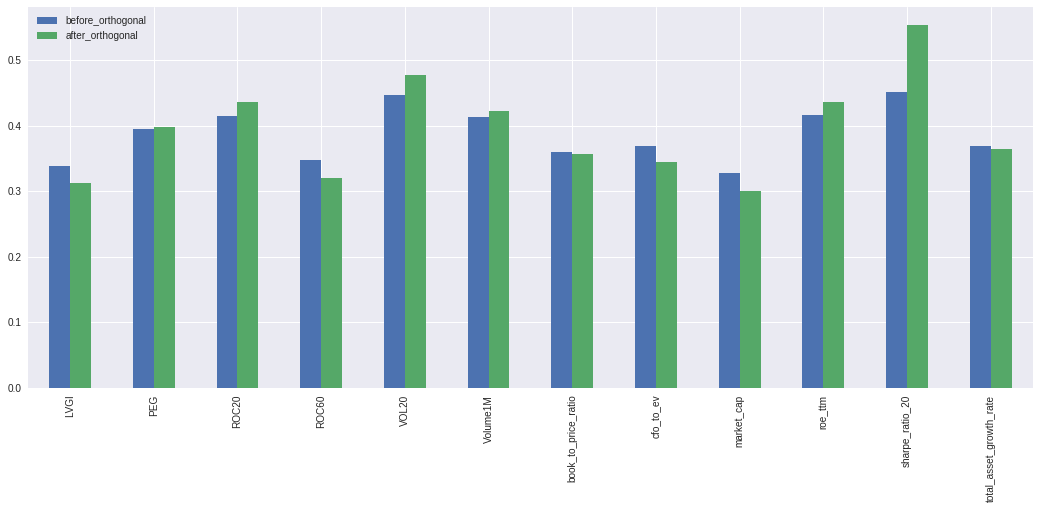

In [20]:
# 绘制对称正交前后择时因子解释能力变化对比柱状图
df = pd.DataFrame()
df['before_orthogonal'] = noorth_R2_mat_all.mean()  # 计算对称正交前的平均拟合优度
df['after_orthogonal'] = R2_mat_all.mean()  # 计算对称正交后的平均拟合优度
df.plot.bar(figsize=(18, 7))

# 七、回测流程及参数设置


`分类模型回测的主要参数设置：`
+ 调仓频率：月度（每月末调仓）；
+ 样本内测试区间：2011-01-01 ~ 2015-12-31；
+ 样本外测试区间：2016-01-01 ~ 2018-10-31；
+ 注：样本内预测区间用于训练各分类模型，寻找最优参数，由于最优参数已找出，所以后面的回测时直接基于最优参数，进行全区间的回测

`对于任意一个因子：`
+ 以正交化后的因子收益的加权移动平均值 w_0作为基础权重（加权移动平均参数：半衰期h，最小期数m）；
+ 滚动过去n期的样本作为训练集，预测未来一期的因子收益方向；
+ 假设模型给出的未来一期因子收益方向预测值为p，(p∈{1,-1})；
+ 假设该因子在过去36个月的因子收益均值的方向为q，(q∈{1,-1})；
+ 如果 p=q，则该因子本期的权重不变；
+ 如果 p≠q，则该因子本期的权重调整为 w_0 × z ,z ∈ (0,1)，此处z为权重调整系数；
+ 基于变量解释能力调整z值：设置参数r2，当滚动过去n期样本的平均决定系数R_square小于阈值r2时，本期因子权重直接采用基础权重而不作调整，即z = 1；当滚动过去n期样本的平均决定系数R_square大于等于阈值r2时，则该因子本期的权重调整为 w_0×z ,z∈(0,1)。



In [21]:
# step1：构建因子收益的加权移动平均函数，作为基础权重
# 输入因子收益和半衰期
def Ret_mat_emw(Ret_mat:pd.DataFrame,period:int)->pd.DataFrame: 
    
    # 指数加权移动平均
    return Ret_mat.ewm(halflife=period,min_periods=2).mean()

In [22]:
weight_in = Ret_mat_emw(Ret_mat,period=3)
weight_in.head()

,LVGI,PEG,ROC20,ROC60,VOL20,Volume1M,book_to_price_ratio,cfo_to_ev,market_cap,roe_ttm,sharpe_ratio_20,total_asset_growth_rate
date,,,,,,,,,,,,
2011-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-28,0.037460,-0.186316,-0.191417,-0.170819,-0.088914,-0.241016,0.078811,-0.099524,-0.147187,0.046746,-0.061546,0.145623
2011-03-31,0.021255,-0.111134,-0.113005,-0.126262,-0.177534,-0.208031,0.195582,-0.002379,-0.050085,0.031667,-0.028889,0.144849
2011-04-29,0.015537,-0.067098,-0.034323,-0.093758,-0.169844,-0.130743,0.122009,0.002279,0.003492,0.047828,-0.002334,0.076055
2011-05-31,0.000837,-0.055413,-0.049605,-0.063075,-0.061680,-0.165503,0.054365,-0.049604,0.016985,0.071120,0.069063,0.083549


In [23]:
# step2:构建分类模型(可通过输入不同的方法method，选择不同的分类模型),预测因子受益方向
def run_predict_models(Ret_mat: pd.DataFrame,
                       df_m_shifted_: pd.DataFrame,
                       method: str,
                       window: int = 24) -> pd.DataFrame:
    '''
    输入因子收益Ret_mat，择时变量df_m_shifted_，
    滚动窗口window为24（每次以24期的数据进行预测，
    其中前23期作为训练集，最后一期作为测试集）
    method:SVM,Logistic,DecisionTree,RandomForest
    '''
    ##初始化数据
    # 获取需要预测的日期序列
    datelist = df_m_shifted_.index.tolist()[window - 1:]

    # 由于因子收益的时间跨度比择时变量的时间跨度大，为保持预测时间上的一致性，
    # 截取与择时变量相同时间跨度的因子收益
    Ret_mat_ = Ret_mat.loc[df_m_shifted_.index.tolist()]

    # 因子收益大于0的赋值为1，小于0的赋值为-1
    Ret_mat_sign = np.sign(Ret_mat_)

    # 获取待预测的因子个数
    num_factor = len(Ret_mat.columns)

    # 提取用于预测的择时因子
    macro_df = df_m_shifted_[[
        'TS', 'CS', 'cpi_yoy', 'ppi', 'STD_Spread', 'RET_Spread', 'm1_yoy',
        'Bond_yield_3M'
    ]]

    ## 用支持向量机进行预测
    # 初始化因子预测数据框,其中起始预测时间为start_date
    predicted_mat = pd.DataFrame(index=datelist, columns=Ret_mat_.columns)

    for j in range(num_factor):

        # 提取分类模型的预测变量，即第j个因子收益
        factor_sign_i = Ret_mat_sign.iloc[:, j]

        # 初始化单个因子的测试值
        predict = pd.Series(0, index=predicted_mat.index.tolist())

        for i in range(len(predict)):

            # 不进行变量缩减,提取预测日期前推window的择时变量数据
            x_design = macro_df.iloc[i:i + window, :]

            # 对数据进行标准化处理
            x_std = x_design.apply(lambda x: (x - x.mean()) / x.std())

            # 以前23期为训练集
            x_train = x_std.iloc[:-1, :]

            # 以最后一期为测试集
            x_test = x_std.iloc[-1:, :]

            # 提取y集
            y_design_logit = factor_sign_i.iloc[i:i + window - 1]

            # 判断选用哪个预测模型
            if method == 'SVM':
                regr = svm.SVC(kernel='rbf')  # 支持向量机核函数选择rbf

            elif method == 'Logistic':
                regr = linear_model.LogisticRegression()  # 导入逻辑回归模型

            elif method == 'DecisionTree':
                regr = DecisionTreeClassifier(max_depth=3)  # 导入决策树模型

            elif method == 'RandomForest':
                regr = RandomForestClassifier(
                    n_estimators=20, max_depth=3,
                    random_state=0)  # 随机森林最大深度为3，n_estimators=20

            regr.fit(x_train.fillna(0), y_design_logit.astype(float))
            predict.iloc[i] = regr.predict(x_test.fillna(0))

        print(Ret_mat.columns[j], "success")  # 打印测试成功的因子

        predicted_mat.iloc[:, j] = predict  # 将各个因子滚动预测的因子收益存入初始化因子预测数据框中

    return predicted_mat

In [24]:
predict_mat = run_predict_models(
    Ret_mat, df_m_shifted_, method='SVM', window=24)
predict_mat.head()

LVGI success
PEG success
ROC20 success
ROC60 success
VOL20 success
Volume1M success
book_to_price_ratio success
cfo_to_ev success
market_cap success
roe_ttm success
sharpe_ratio_20 success
total_asset_growth_rate success


,LVGI,PEG,ROC20,ROC60,VOL20,Volume1M,book_to_price_ratio,cfo_to_ev,market_cap,roe_ttm,sharpe_ratio_20,total_asset_growth_rate
2012-12-31,1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0
2013-01-31,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0
2013-02-28,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0
2013-03-29,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0
2013-04-26,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0


In [25]:
#step4:计算滚动过去n期样本的平均决定系数R_square
r2 = rolling_R2(df_m_shifted_.fillna(0), Ret_mat.fillna(0), window=24)
r2.head()

,LVGI,PEG,ROC20,ROC60,VOL20,Volume1M,book_to_price_ratio,cfo_to_ev,market_cap,roe_ttm,sharpe_ratio_20,total_asset_growth_rate
2012-12-31,0.0510165,0.173187,0.300352,0.213769,0.288701,0.397229,0.461012,0.134817,0.37171,0.458406,0.155312,0.428146
2013-01-31,0.0579054,0.0901847,0.33236,0.169299,0.287314,0.357015,0.443073,0.110358,0.301963,0.412385,0.43722,0.435519
2013-02-28,0.05469,0.161903,0.33188,0.150858,0.270569,0.334043,0.316359,0.113004,0.21819,0.396523,0.463417,0.386656
2013-03-29,0.137092,0.183353,0.35711,0.146261,0.189245,0.332555,0.354691,0.0673482,0.217751,0.455631,0.573672,0.417879
2013-04-26,0.137166,0.164621,0.379014,0.214478,0.163499,0.357639,0.344958,0.0776939,0.229596,0.438512,0.553267,0.465659


In [40]:
#step5:构建权重调整函数
def weight_timing_threshold(Ret_mat: pd.DataFrame,
                            predict_mat: pd.DataFrame,
                            weight_in: pd.DataFrame,
                            r2: pd.DataFrame,
                            th: float,
                            z: float = 0.1) -> pd.DataFrame:
    '''
    输入参数：Ret_mat（因子收益数据集），
    predict_mat（预测的因子收益方向），
    weight_in（初始权重），
    r2(拟合优度R2)，
    th(阈值),
    z(权重调整系数)
    '''
    predict_mat.dropna(inplace=True)  # 删除预期收益的缺失值

    # 计算过去36个月的因子收益均值
    factor_sign = np.sign(Ret_mat.rolling(min_periods=1, window=36).mean())

    # 初始化新的因子权重
    weight_new = pd.DataFrame(
        0, index=predict_mat.index, columns=weight_in.columns)

    # 提取预期因子收益时间对应的原始因子权重集
    weight_in_chunk = weight_in.loc[predict_mat.index, :]

    for j in range(len(weight_new.index)):
        # 判断预测的因子收益方向是否发生变化，若发生变化则需要调整权重
        iftrue = pd.Series(predict_mat.loc[weight_new.index[j], :] ==
                           factor_sign.loc[weight_new.index[j], :])

        time_weight = iftrue.apply(lambda x: 1 if x == True else z)
        # 调整因子权重
        weight_new.iloc[j, :] = weight_in_chunk.iloc[j, :] * time_weight

        # 根据拟合优度判断是否有变换权重的资格
        aa = r2.loc[weight_new.index[j], :]  # 提取对应日期的过去n期的r2
        for name in weight_new.columns:
            if aa[name] < th:
                weight_new.loc[:, name] = weight_in_chunk.loc[:, name].astype(
                    float)  # 当拟合优度小于阈值时，权重保持不变

    return weight_new

In [29]:
weight_new = weight_timing_threshold(
    Ret_mat, predict_mat, weight_in, r2, th=0.05, z=0.1)
weight_new.head()

,LVGI,PEG,ROC20,ROC60,VOL20,Volume1M,book_to_price_ratio,cfo_to_ev,market_cap,roe_ttm,sharpe_ratio_20,total_asset_growth_rate
2012-12-31,-0.029785,0.025974,-0.071259,-0.004482,-0.036303,-0.050228,0.013749,-0.032974,0.051352,0.021932,0.121678,0.030551
2013-01-31,-0.003086,0.041586,-0.035746,-0.044222,-0.018383,-0.061970,0.080987,-0.005590,0.004063,0.042738,0.131450,0.020949
2013-02-28,0.026298,0.070942,0.009301,-0.025911,-0.099144,-0.072432,0.003545,-0.027458,-0.014554,0.054978,0.177616,0.041666
2013-03-29,0.016106,0.053079,-0.002810,-0.010726,-0.081144,-0.094617,0.002742,-0.003835,0.002229,0.026993,0.150334,0.067063
2013-04-26,0.016179,0.031828,0.008957,0.002916,0.007852,-0.076144,-0.002356,-0.044393,-0.007112,0.009735,0.174176,0.044186


# 八、 三种分类模型的参数选取
我们将会构建支持向量机（SVM）、随机森林（Random Forest）、逻辑回归（Logistic）3种分类模型预测因子收益，然后根据滚动预测的结果进行权重调整。

三种分类模型的样本内优化后的参数选取如下：

|SVM|取值|Random Forest|取值|Logistic|取值|
|:---:|:---:|:---:|:---:|:---:|:---:|
|训练集长度n|24|训练集长度n|20|训练集长度n|36|
|半衰期h|3|半衰期h|3|半衰期h|3|
|权重调整系数z|0.1|权重调整系数z|0.1|权重调整系数z|0.2|
|阈值r2|0.05|阈值r2|0|阈值r2|0.1|
|核函数|rbt|最大深度|3|-|-|
|-|-|n_estimators|20|-|-|

 *根据测试发现并不是训练时间越长越好,这里直接给出结果*

# 九、SVM预测能力较强，随机森林表现稳定

In [30]:
#定义计算预测准确度函数
def get_accuracy(predict_mat: pd.DataFrame, Ret_mat: pd.DataFrame,
                 method: str) -> pd.DataFrame:
    
    ret_mat_sign = np.sign(Ret_mat.loc[predict_mat.index, :])
    accuracy = pd.DataFrame(index=[method])
    
    for name in predict_mat.columns:
        iftrue = pd.Series(predict_mat[name] == ret_mat_sign[name])
        accuracy[name] = iftrue.sum() / len(predict_mat)
    return accuracy.T

In [31]:
#计算SVM的预测准确率
predict_mat = run_predict_models(
    Ret_mat, df_m_shifted_, method='SVM', window=24)
SVM_accuracy = get_accuracy(predict_mat, Ret_mat, method='SVM')

LVGI success
PEG success
ROC20 success
ROC60 success
VOL20 success
Volume1M success
book_to_price_ratio success
cfo_to_ev success
market_cap success
roe_ttm success
sharpe_ratio_20 success
total_asset_growth_rate success


In [32]:
#计算随机森林的预测准确率
predict_mat = run_predict_models(
    Ret_mat, df_m_shifted_, method='RandomForest', window=20)
RF_accuracy = get_accuracy(predict_mat, Ret_mat, method='RandomForest')

LVGI success
PEG success
ROC20 success
ROC60 success
VOL20 success
Volume1M success
book_to_price_ratio success
cfo_to_ev success
market_cap success
roe_ttm success
sharpe_ratio_20 success
total_asset_growth_rate success


In [33]:
#计算逻辑回归的预测准确率
predict_mat = run_predict_models(
    Ret_mat, df_m_shifted_, method='Logistic', window=36)
LOG_accuracy = get_accuracy(predict_mat, Ret_mat, method='Logistic')

LVGI success
PEG success
ROC20 success
ROC60 success
VOL20 success
Volume1M success
book_to_price_ratio success
cfo_to_ev success
market_cap success
roe_ttm success
sharpe_ratio_20 success
total_asset_growth_rate success


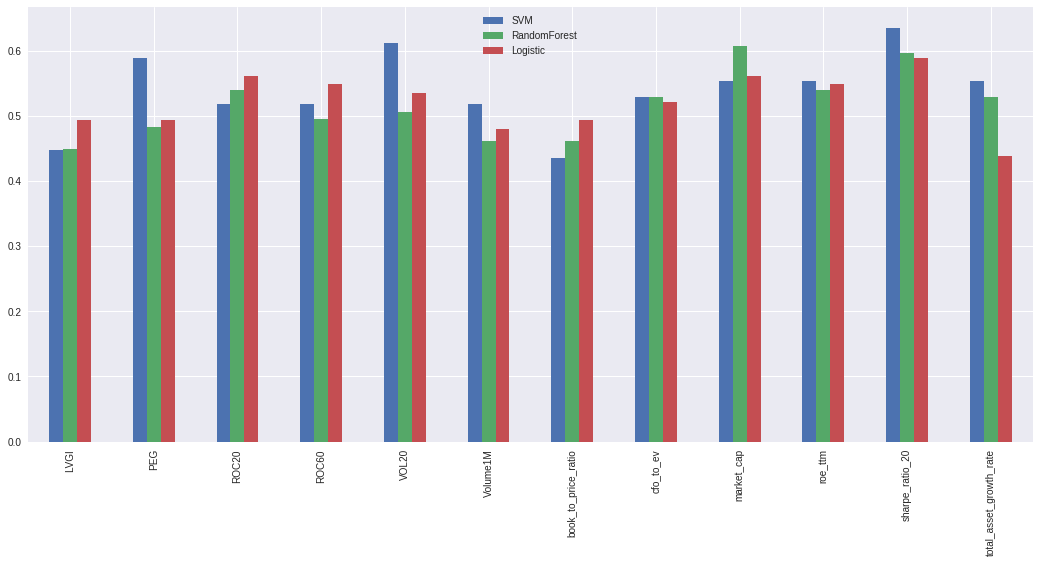

In [34]:
#绘制预测准确度对比柱状图
df = pd.concat([SVM_accuracy, RF_accuracy, LOG_accuracy], axis=1)
df.plot.bar(figsize=(18, 8))

# 十、 随机森林和SVM的收益提升较为明显

In [35]:
datas_all = pd.read_csv(
    '../Data/SVM_timing_datas.csv', index_col=[0, 1])  #读取对称正交后的数据集

datas = datas_all[[
    i for i in datas_all.columns if i not in ['cap', 'log_ret', 'INDUSTRY']
]]  #提取因子数据

datas.head()

LVGI           ...             total_asset_growth_rate
date       code                            ...                                    
2011-01-31 000001.XSHE -0.005361           ...                           -0.016647
           000002.XSHE -0.020450           ...                            0.060002
           000009.XSHE -0.003415           ...                            0.030863
           000012.XSHE -0.042559           ...                           -0.073062
           000021.XSHE  0.136461           ...                            0.005247

[5 rows x 12 columns]

In [36]:
# 用于回测调用
Ret_mat.to_csv('../Data/Ret_mat.csv')
datas.to_csv('../Data/datas.csv')
df_m_shifted_.to_csv('../Data/df_m_shifted_.csv')
weight_in.to_csv('../Data/weight_in.csv')

In [45]:
# 定义类'参数分析'
class parameter_analysis(object):

    # 定义函数中不同的变量
    def __init__(self, algorithm_id=None):
        self.algorithm_id = algorithm_id  # 回测id

        self.params_df = pd.DataFrame(
        )  # 回测中所有调参备选值的内容，列名字为对应修改面两名称，对应回测中的 g.XXXX
        self.results = {}  # 回测结果的回报率，key 为 params_df 的行序号，value 为
        self.evaluations = {
        }  # 回测结果的各项指标，key 为 params_df 的行序号，value 为一个 dataframe
        self.backtest_ids = {}  # 回测结果的 id

        # 新加入的基准的回测结果 id，可以默认为空 ''，则使用回测中设定的基准
        self.benchmark_id = 'f16629492d6b6f4040b2546262782c78'
        
        self.benchmark_returns = []  # 新加入的基准的回测回报率
        self.returns = {}  # 记录所有回报率
        self.excess_returns = {}  # 记录超额收益率
        self.log_returns = {}  # 记录收益率的 log 值
        self.log_excess_returns = {}  # 记录超额收益的 log 值
        self.dates = []  # 回测对应的所有日期
        self.excess_max_drawdown = {}  # 计算超额收益的最大回撤
        self.excess_annual_return = {}  # 计算超额收益率的年化指标
        self.evaluations_df = pd.DataFrame()  # 记录各项回测指标，除日回报率外
        self.failed_list = []
        self.nav_df = pd.DataFrame()
        
    # 定义排队运行多参数回测函数
    def run_backtest(
            self,  #
            algorithm_id=None,  # 回测策略id
            running_max=10,  # 回测中同时巡行最大回测数量
            start_date='2006-01-01',  # 回测的起始日期
            end_date='2016-11-30',  # 回测的结束日期
            frequency='day',  # 回测的运行频率
            initial_cash='1000000',  # 回测的初始持仓金额
            param_names=[],  # 回测中调整参数涉及的变量
            param_values=[],  # 回测中每个变量的备选参数值
            python_version=2,  # 回测的python版本
            use_credit=False  # 是否允许消耗积分继续回测
    ):
        # 当此处回测策略的 id 没有给出时，调用类输入的策略 id
        if algorithm_id == None:
            algorithm_id = self.algorithm_id

        # 生成所有参数组合并加载到 df 中
        # 包含了不同参数具体备选值的排列组合中一组参数的 tuple 的 list
        param_combinations = list(itertools.product(*param_values))
        # 生成一个 dataframe， 对应的列为每个调参的变量，每个值为调参对应的备选值
        to_run_df = pd.DataFrame(param_combinations, dtype='object')
        # 修改列名称为调参变量的名字
        to_run_df.columns = param_names

        # 设定运行起始时间和保存格式
        start = time.time()
        # 记录结束的运行回测
        finished_backtests = {}
        # 记录运行中的回测
        running_backtests = {}
        # 计数器
        pointer = 0
        # 总运行回测数目，等于排列组合中的元素个数
        total_backtest_num = len(param_combinations)
        # 记录回测结果的回报率
        all_results = {}
        # 记录回测结果的各项指标
        all_evaluations = {}

        # 在运行开始时显示
        print(('【已完成|运行中|待运行】:'), end=' ')
        # 当运行回测开始后，如果没有全部运行完全的话：
        while len(finished_backtests) < total_backtest_num:
            # 显示运行、完成和待运行的回测个数
            print(('[%s|%s|%s].' %
                   (len(finished_backtests), len(running_backtests),
                    (total_backtest_num - len(finished_backtests) -
                     len(running_backtests)))),
                  end=' ')
            # 记录当前运行中的空位数量
            to_run = min(
                running_max - len(running_backtests), total_backtest_num -
                len(running_backtests) - len(finished_backtests))
            # 把可用的空位进行跑回测
            for i in range(pointer, pointer + to_run):
                # 备选的参数排列组合的 df 中第 i 行变成 dict，每个 key 为列名字，value 为 df 中对应的值
                params = to_run_df.iloc[i].to_dict()
                # 记录策略回测结果的 id，调整参数 extras 使用 params 的内容
                backtest = create_backtest(
                    algorithm_id=algorithm_id,
                    start_date=start_date,
                    end_date=end_date,
                    frequency=frequency,
                    initial_cash=initial_cash,
                    extras=params,
                    # 再回测中把改参数的结果起一个名字，包含了所有涉及的变量参数值
                    name=str(params),
                    python_version=python_version,
                    use_credit=use_credit)
                # 记录运行中 i 回测的回测 id
                running_backtests[i] = backtest
            # 计数器计数运行完的数量
            pointer = pointer + to_run

            # 获取回测结果
            failed = []
            finished = []
            # 对于运行中的回测，key 为 to_run_df 中所有排列组合中的序数
            for key in list(running_backtests.keys()):
                # 研究调用回测的结果，running_backtests[key] 为运行中保存的结果 id
                back_id = running_backtests[key]
                bt = get_backtest(back_id)
                # 获得运行回测结果的状态，成功和失败都需要运行结束后返回，如果没有返回则运行没有结束
                status = bt.get_status()
                # 当运行回测失败
                if status == 'failed':
                    # 失败 list 中记录对应的回测结果 id
                    print('')
                    print((
                        '回测失败 : https://www.joinquant.com/algorithm/backtest/detail?backtestId='
                        + back_id))
                    failed.append(key)
                # 当运行回测成功时
                elif status == 'done':
                    # 成功 list 记录对应的回测结果 id，finish 仅记录运行成功的
                    finished.append(key)
                    # 回测回报率记录对应回测的回报率 dict， key to_run_df 中所有排列组合中的序数， value 为回报率的 dict
                    # 每个 value 一个 list 每个对象为一个包含时间、日回报率和基准回报率的 dict
                    all_results[key] = bt.get_results()
                    # 回测回报率记录对应回测结果指标 dict， key to_run_df 中所有排列组合中的序数， value 为回测结果指标的 dataframe
                    all_evaluations[key] = bt.get_risk()
            # 记录运行中回测结果 id 的 list 中删除失败的运行
            for key in failed:
                finished_backtests[key] = running_backtests.pop(key)
            # 在结束回测结果 dict 中记录运行成功的回测结果 id，同时在运行中的记录中删除该回测
            for key in finished:
                finished_backtests[key] = running_backtests.pop(key)
#                 print (finished_backtests)
# 当一组同时运行的回测结束时报告时间
            if len(finished_backtests) != 0 and len(
                    finished_backtests) % running_max == 0 and to_run != 0:
                # 记录当时时间
                middle = time.time()
                # 计算剩余时间，假设没工作量时间相等的话
                remain_time = (middle - start) * (
                    total_backtest_num -
                    len(finished_backtests)) / len(finished_backtests)
                # print 当前运行时间
                print(
                    ('[已用%s时,尚余%s时,请不要关闭浏览器].' %
                     (str(round((middle - start) / 60.0 / 60.0,
                                3)), str(round(remain_time / 60.0 / 60.0, 3)))),
                    end=' ')
            self.failed_list += failed
            # 5秒钟后再跑一下
            time.sleep(5)
        # 记录结束时间
        end = time.time()
        print('')
        print(
            ('【回测完成】总用时：%s秒(即%s小时)。' %
             (str(int(end - start)), str(round(
                 (end - start) / 60.0 / 60.0, 2)))),
            end=' ')
        #         print (to_run_df,all_results,all_evaluations,finished_backtests)
        # 对应修改类内部对应
        #         to_run_df = {key:value for key,value in returns.items() if key not in faild}
        self.params_df = to_run_df
        #         all_results = {key:value for key,value in all_results.items() if key not in faild}
        self.results = all_results
        #         all_evaluations = {key:value for key,value in all_evaluations.items() if key not in faild}
        self.evaluations = all_evaluations
        #         finished_backtests = {key:value for key,value in finished_backtests.items() if key not in faild}
        self.backtest_ids = finished_backtests

    #7 最大回撤计算方法
    def find_max_drawdown(self, returns):
        # 定义最大回撤的变量
        result = 0
        # 记录最高的回报率点
        historical_return = 0
        # 遍历所有日期
        for i in range(len(returns)):
            # 最高回报率记录
            historical_return = max(historical_return, returns[i])
            # 最大回撤记录
            drawdown = 1 - (returns[i] + 1) / (historical_return + 1)
            # 记录最大回撤
            result = max(drawdown, result)
        # 返回最大回撤值
        return result

    # log 收益、新基准下超额收益和相对与新基准的最大回撤
    def organize_backtest_results(self, benchmark_id=None):
        # 若新基准的回测结果 id 没给出
        if benchmark_id == None:
            # 使用默认的基准回报率，默认的基准在回测策略中设定
            self.benchmark_returns = [
                x['benchmark_returns'] for x in self.results[0]
            ]
        # 当新基准指标给出后
        else:
            # 基准使用新加入的基准回测结果
            self.benchmark_returns = [
                x['returns'] for x in get_backtest(benchmark_id).get_results()
            ]
        # 回测日期为结果中记录的第一项对应的日期
        self.dates = [x['time'] for x in self.results[0]]

        # 对应每个回测在所有备选回测中的顺序 （key），生成新数据
        # 由 {key：{u'benchmark_returns': 0.022480100091729405,
        #           u'returns': 0.03184566700000002,
        #           u'time': u'2006-02-14'}} 格式转化为：
        # {key: []} 格式，其中 list 为对应 date 的一个回报率 list
        for key in list(self.results.keys()):
            self.returns[key] = [x['returns'] for x in self.results[key]]
        # 生成对于基准（或新基准）的超额收益率
        for key in list(self.results.keys()):
            self.excess_returns[key] = [
                (x + 1) / (y + 1) - 1
                for (x, y) in zip(self.returns[key], self.benchmark_returns)
            ]
        # 生成 log 形式的收益率
        for key in list(self.results.keys()):
            self.log_returns[key] = [log(x + 1) for x in self.returns[key]]
        # 生成超额收益率的 log 形式
        for key in list(self.results.keys()):
            self.log_excess_returns[key] = [
                log(x + 1) for x in self.excess_returns[key]
            ]
        # 生成超额收益率的最大回撤
        for key in list(self.results.keys()):
            self.excess_max_drawdown[key] = self.find_max_drawdown(
                self.excess_returns[key])
        # 生成年化超额收益率
        for key in list(self.results.keys()):
            self.excess_annual_return[key] = (self.excess_returns[key][-1] +
                                              1)**(252. /
                                                   float(len(self.dates))) - 1
        # 把调参数据中的参数组合 df 与对应结果的 df 进行合并
        self.evaluations_df = pd.concat(
            [self.params_df, pd.DataFrame(self.evaluations).T], axis=1)


#         self.evaluations_df =

# 获取最总分析数据，调用排队回测函数和数据整理的函数

    def get_backtest_data(
            self,
            algorithm_id=None,  # 回测策略id
            benchmark_id=None,  # 新基准回测结果id
            file_name='results.pkl',  # 保存结果的 pickle 文件名字
            running_max=10,  # 最大同时运行回测数量
            start_date='2006-01-01',  # 回测开始时间
            end_date='2016-11-30',  # 回测结束日期
            frequency='day',  # 回测的运行频率
            initial_cash='1000000',  # 回测初始持仓资金
            param_names=[],  # 回测需要测试的变量
            param_values=[],  # 对应每个变量的备选参数
            python_version=2,
            use_credit=False):
        # 调运排队回测函数，传递对应参数
        self.run_backtest(
            algorithm_id=algorithm_id,
            running_max=running_max,
            start_date=start_date,
            end_date=end_date,
            frequency=frequency,
            initial_cash=initial_cash,
            param_names=param_names,
            param_values=param_values,
            python_version=python_version,
            use_credit=use_credit,
        )
        # 回测结果指标中加入 log 收益率和超额收益率等指标
        self.organize_backtest_results(benchmark_id)
        # 生成 dict 保存所有结果。
        results = {
            'returns': self.returns,
            'excess_returns': self.excess_returns,
            'log_returns': self.log_returns,
            'log_excess_returns': self.log_excess_returns,
            'dates': self.dates,
            'benchmark_returns': self.benchmark_returns,
            'evaluations': self.evaluations,
            'params_df': self.params_df,
            'backtest_ids': self.backtest_ids,
            'excess_max_drawdown': self.excess_max_drawdown,
            'excess_annual_return': self.excess_annual_return,
            'evaluations_df': self.evaluations_df,
            "failed_list": self.failed_list
        }
        # 保存 pickle 文件
        pickle_file = open(file_name, 'wb')
        pickle.dump(results, pickle_file)
        pickle_file.close()

    # 读取保存的 pickle 文件，赋予类中的对象名对应的保存内容
    def read_backtest_data(self, file_name='results.pkl'):
        pickle_file = open(file_name, 'rb')
        results = pickle.load(pickle_file)
        self.returns = results['returns']
        self.excess_returns = results['excess_returns']
        self.log_returns = results['log_returns']
        self.log_excess_returns = results['log_excess_returns']
        self.dates = results['dates']
        self.benchmark_returns = results['benchmark_returns']
        self.evaluations = results['evaluations']
        self.params_df = results['params_df']
        self.backtest_ids = results['backtest_ids']
        self.excess_max_drawdown = results['excess_max_drawdown']
        self.excess_annual_return = results['excess_annual_return']
        self.evaluations_df = results['evaluations_df']
        self.failed_list = results['failed_list']
        self.nav_df = self.GetNavDf()

    # 回报率折线图
    def plot_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20, 8))
        ax = fig.add_subplot(111)
        # 作图
        for key in list(self.returns.keys()):
            ax.plot(
                list(range(len(self.returns[key]))),
                self.returns[key],
                label=key)
        # 设定benchmark曲线并标记
        ax.plot(
            list(range(len(self.benchmark_returns))),
            self.benchmark_returns,
            label='benchmark',
            c='k',
            linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates) - 1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc=2, fontsize=10)
        # 设置y标签样式
        ax.set_ylabel('returns', fontsize=20)
        # 设置x标签样式
        ax.set_yticklabels([str(x * 100) + '% ' for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title(
            "Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.returns[0]))

    # 超额收益率图
    def plot_excess_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20, 8))
        ax = fig.add_subplot(111)
        # 作图
        for key in list(self.returns.keys()):
            ax.plot(
                list(range(len(self.excess_returns[key]))),
                self.excess_returns[key],
                label=key)
        # 设定benchmark曲线并标记
        ax.plot(
            list(range(len(self.benchmark_returns))),
            [0] * len(self.benchmark_returns),
            label='benchmark',
            c='k',
            linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates) - 1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc=2, fontsize=10)
        # 设置y标签样式
        ax.set_ylabel('excess returns', fontsize=20)
        # 设置x标签样式
        ax.set_yticklabels([str(x * 100) + '% ' for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title(
            "Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.excess_returns[0]))

        
    # 回测的4个主要指标，包括总回报率、最大回撤夏普率和波动
    def get_eval4_bar(self, sort_by=[]):

        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        indices = set(sorted_params.index) - set(self.failed_list)
        fig = plt.figure(figsize=(20, 7))

        # 定义位置
        ax1 = fig.add_subplot(221)
        # 设定横轴为对应分位，纵轴为对应指标
        ax1.bar(
            list(range(len(indices))),
            [self.evaluations[x]['algorithm_return'] for x in indices],
            0.6,
            label='Algorithm_return')
        plt.xticks([x + 0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax1.legend(loc='best', fontsize=15)
        # 设置y标签样式
        ax1.set_ylabel('Algorithm_return', fontsize=15)
        # 设置y标签样式
        ax1.set_yticklabels([str(x * 100) + '% ' for x in ax1.get_yticks()])
        # 设置图片标题样式
        ax1.set_title(
            "Strategy's of Algorithm_return performances of different quantile",
            fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax2 = fig.add_subplot(224)
        # 设定横轴为对应分位，纵轴为对应指标
        ax2.bar(
            list(range(len(indices))),
            [self.evaluations[x]['max_drawdown'] for x in indices],
            0.6,
            label='Max_drawdown')
        plt.xticks([x + 0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax2.legend(loc='best', fontsize=15)
        # 设置y标签样式
        ax2.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax2.set_yticklabels([str(x * 100) + '% ' for x in ax2.get_yticks()])
        # 设置图片标题样式
        ax2.set_title(
            "Strategy's of Max_drawdown performances of different quantile",
            fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax3 = fig.add_subplot(223)
        # 设定横轴为对应分位，纵轴为对应指标
        ax3.bar(
            list(range(len(indices))),
            [self.evaluations[x]['sharpe'] for x in indices],
            0.6,
            label='Sharpe')
        plt.xticks([x + 0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax3.legend(loc='best', fontsize=15)
        # 设置y标签样式
        ax3.set_ylabel('Sharpe', fontsize=15)
        # 设置x标签样式
        ax3.set_yticklabels([str(x * 100) + '% ' for x in ax3.get_yticks()])
        # 设置图片标题样式
        ax3.set_title(
            "Strategy's of Sharpe performances of different quantile",
            fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax4 = fig.add_subplot(222)
        # 设定横轴为对应分位，纵轴为对应指标
        ax4.bar(
            list(range(len(indices))),
            [self.evaluations[x]['algorithm_volatility'] for x in indices],
            0.6,
            label='Algorithm_volatility')
        plt.xticks([x + 0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax4.legend(loc='best', fontsize=15)
        # 设置y标签样式
        ax4.set_ylabel('Algorithm_volatility', fontsize=15)
        # 设置x标签样式
        ax4.set_yticklabels([str(x * 100) + '% ' for x in ax4.get_yticks()])
        # 设置图片标题样式
        ax4.set_title(
            "Strategy's of Algorithm_volatility performances of different quantile",
            fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

    #14 年化回报和最大回撤，正负双色表示
    def get_eval(self, sort_by=[]):

        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        indices = set(sorted_params.index) - set(self.failed_list)
        # 大小
        fig = plt.figure(figsize=(20, 8))
        # 图1位置
        ax = fig.add_subplot(111)
        # 生成图超额收益率的最大回撤
        ax.bar([x + 0.3 for x in range(len(indices))],
               [-self.evaluations[x]['max_drawdown'] for x in indices],
               color='#32CD32',
               width=0.6,
               label='Max_drawdown',
               zorder=10)
        # 图年化超额收益
        ax.bar([x for x in range(len(indices))],
               [self.evaluations[x]['annual_algo_return'] for x in indices],
               color='r',
               width=0.6,
               label='Annual_return')
        plt.xticks([x + 0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax.legend(loc='best', fontsize=15)
        # 基准线
        plt.plot([0, len(indices)], [0, 0], c='k', linestyle='--', label='zero')
        # 设置图例样式
        ax.legend(loc='best', fontsize=15)
        # 设置y标签样式
        ax.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax.set_yticklabels([str(x * 100) + '% ' for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title(
            "Strategy's performances of different quantile", fontsize=15)
        #   设定x轴长度
        plt.xlim(0, len(indices))

    #14 超额收益的年化回报和最大回撤
    # 加入新的benchmark后超额收益和
    def get_excess_eval(self, sort_by=[]):

        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        indices = set(sorted_params.index) - set(self.failed_list)
        # 大小
        fig = plt.figure(figsize=(20, 8))
        # 图1位置
        ax = fig.add_subplot(111)
        # 生成图超额收益率的最大回撤
        ax.bar([x + 0.3 for x in range(len(indices))],
               [-self.excess_max_drawdown[x] for x in indices],
               color='#32CD32',
               width=0.6,
               label='Excess_max_drawdown')
        # 图年化超额收益
        ax.bar([x for x in range(len(indices))],
               [self.excess_annual_return[x] for x in indices],
               color='r',
               width=0.6,
               label='Excess_annual_return')
        plt.xticks([x + 0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax.legend(loc='best', fontsize=15)
        # 基准线
        plt.plot([0, len(indices)], [0, 0], c='k', linestyle='--', label='zero')
        # 设置图例样式
        ax.legend(loc='best', fontsize=15)
        # 设置y标签样式
        ax.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax.set_yticklabels([str(x * 100) + '% ' for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title(
            "Strategy's performances of different quantile", fontsize=15)
        #   设定x轴长度
        plt.xlim(0, len(indices))
    
    def GetNavDf(self):
        
        df = 1 + pd.DataFrame(self.returns,index=self.dates)
        df.columns = ['SVM','Logistic','RandomForest','not_timing']
        df['benchmark'] = self.benchmark_returns
        df.index=pd.to_datetime(df.index)
        return df
        
    #计算组合收益率分析:年化收益率、收益波动率、夏普比率、最大回撤
    def strategy_performance(self,nav_df=None):
        
        if isinstance(nav_df,pd.DataFrame):
            
            nav_df = nav_df
        else:
            nav_df = self.nav_df
        ##part1:根据回测净值计算相关指标的数据准备（日度数据）
        nav_next = nav_df.shift(1)
        return_df = (nav_df - nav_next) / nav_next  #计算净值变化率，即为日收益率,包含组合与基准
        return_df = return_df.dropna()  #在计算净值变化率时，首日得到的是缺失值，需将其删除

        analyze = pd.DataFrame()  #用于存储计算的指标

        ##part2:计算年化收益率
        cum_return = np.exp(np.log1p(return_df).cumsum()) - 1  #计算整个回测期内的复利收益率
        annual_return_df = (1 + cum_return)**(252 / len(return_df)) - 1  #计算年化收益率
        analyze['annual_return'] = annual_return_df.iloc[-1]  #将年化收益率的Series赋值给数据框

        #part3:计算收益波动率（以年为基准）
        analyze['return_volatility'] = return_df.std() * np.sqrt(
            252)  #return中的收益率为日收益率，所以计算波动率转化为年时，需要乘上np.sqrt(252)

        #part4:计算夏普比率
        risk_free = 0
        return_risk_adj = return_df - risk_free
        analyze['sharpe_ratio'] = return_risk_adj.mean() / np.std(
            return_risk_adj, ddof=1)

        #prat5:计算最大回撤
        cumulative = np.exp(np.log1p(return_df).cumsum()) * 100  #计算累计收益率
        max_return = cumulative.cummax()  #计算累计收益率的在各个时间段的最大值
        analyze['max_drawdown'] = cumulative.sub(max_return).div(
            max_return).min()  #最大回撤一般小于0，越小，说明离1越远，各时间点与最大收益的差距越大

        #part6:计算相对指标
        analyze['relative_return'] = analyze['annual_return'] - analyze.loc[
            'benchmark', 'annual_return']  #计算相对年化波动率
        analyze['relative_volatility'] = analyze['return_volatility'] - analyze.loc[
            'benchmark', 'return_volatility']  #计算相对波动
        analyze['relative_drawdown'] = analyze['max_drawdown'] - analyze.loc[
            'benchmark', 'max_drawdown']  #计算相对最大回撤

        #part6:计算信息比率
        return_diff = return_df.sub(
            return_df['benchmark'], axis=0).std() * np.sqrt(
                252)  #计算策略与基准日收益差值的年化标准差
        analyze['info_ratio'] = analyze['relative_return'].div(return_diff)

        return analyze.T


    #构建每年的收益表现函数
    def get_return_year(self,method):
        
        nav = self.nav_df[['benchmark',method]]
        result_dic = {}  #用于存储每年计算的各项指标
        for y,nav_df in nav.groupby(pd.Grouper(level=0,freq='Y')):

            result = self.strategy_performance(nav_df)
            result_dic[str(y)[:4]] = result.iloc[:, -1]

        result_df = pd.DataFrame(result_dic)
      
        return result_df.T


In [46]:
#2 设定回测的 策略id 
pa = parameter_analysis('a46bf5ddd29f2ce407d284e4bb01a6ee')

In [16]:
#3 运行回测
pa.get_backtest_data(file_name = 'results.pkl',  # 保存回测结果的Pickle文件名
                          running_max = 2,      # 同时回测的最大个数,可以通过积分商城兑换
                          benchmark_id = None,   # 基准的回测ID,注意是回测ID而不是策略ID,为None时为策略中使用的基准
                          start_date = '2014-01-01', #回测开始时间
                          end_date = '2019-12-31',   #回测结束时间
                          frequency = 'day',         #回测频率,支持 day, minute, tick 
                          initial_cash = '5000000',  #初始资金
                          param_names = ['method'],  #变量名称
                          param_values = [['SVM','Logistic','RandomForest','not_timing']],  #变量对应的参数
                          python_version = 3   # 回测python版本
                          )

【已完成|运行中|待运行】: [0|0|4]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [0|2|2]. [1|1|2]. [1|2|1]. [1|2|1]. [1|2|1]. [1|2|1]. [1|2|1]. [1|2|1]. [1|2|1]. [2|1|1]. [已用0.072时,尚余0.072时,请不要关闭浏览器]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [2|2|0]. [3|1|0]. [3|1|0]. [3|1|0]. [3|1|0]. [3|1|0]. [3|1|0]. [3|1|0]. [3|1|0]. [3|1|0]. [3|1|0]. [3|1|0]. [3|1|0]. [3|1|0]. 
【回测完成】总用时：488秒(即0.14小时)。 

In [47]:
#4 数据读取 已经运行过直接读取就可以
pa.read_backtest_data('results.pkl')

In [48]:
#6 查看回测结果指标
print_table(pa.strategy_performance())
print_table(pa.get_return_year('SVM'))
print_table(pa.evaluations_df.T)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:588: RuntimeWarning: invalid value encountered in log1p
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:603: RuntimeWarning: invalid value encountered in log1p


,SVM,Logistic,RandomForest,not_timing,benchmark
annual_return,0.371384,0.395206,0.081977,0.368583,3.236285
return_volatility,0.258946,0.257669,0.271958,0.255917,33.531337
sharpe_ratio,0.085086,0.089640,0.026892,0.085392,-0.011165
max_drawdown,-0.387147,-0.418825,-0.552289,-0.380277,-0.981639
relative_return,-2.864900,-2.841078,-3.154308,-2.867701,0.000000
relative_volatility,-33.272391,-33.273668,-33.259379,-33.275420,0.000000
relative_drawdown,0.594492,0.562815,0.429350,0.601363,0.000000
info_ratio,-0.085443,-0.084733,-0.094067,-0.085526,NaN


,annual_return,return_volatility,sharpe_ratio,max_drawdown,relative_return,relative_volatility,relative_drawdown,info_ratio
2014,1.099792,0.224587,0.215394,-0.111590,-3863.881091,-81.977843,0.870049,-47.001906
2015,0.484994,0.421962,0.072478,-0.361505,0.414161,-0.622279,0.408428,0.618584
2016,0.050648,0.258483,0.020246,-0.219820,0.195008,-0.554913,0.347267,0.341932
2017,0.375174,0.102547,0.199046,-0.052014,-0.337757,-0.171973,0.099371,-1.762492
2018,-0.078880,0.192486,-0.020834,-0.160097,0.548713,-0.491310,0.519260,1.077565
2019,0.635615,0.225380,0.144691,-0.169371,-1.232669,-0.327385,0.141103,-3.420030


,0,1,2,3
method,SVM,Logistic,RandomForest,not_timing
__version,101,101,101,101
algorithm_return,5.91364,5.25583,5.18202,0.579988
algorithm_volatility,0.256558,0.257829,0.254813,0.270784
alpha,0.289332,0.265174,0.263378,-0.0250981
annual_algo_return,0.391209,0.367658,0.364889,0.0812425
annual_bm_return,0.101153,0.101153,0.101153,0.101153
avg_excess_return,0.000952917,0.000883705,0.00087605,-5.69881e-05
avg_position_days,NaN,NaN,NaN,165.23
avg_trade_return,NaN,NaN,NaN,0.0899963


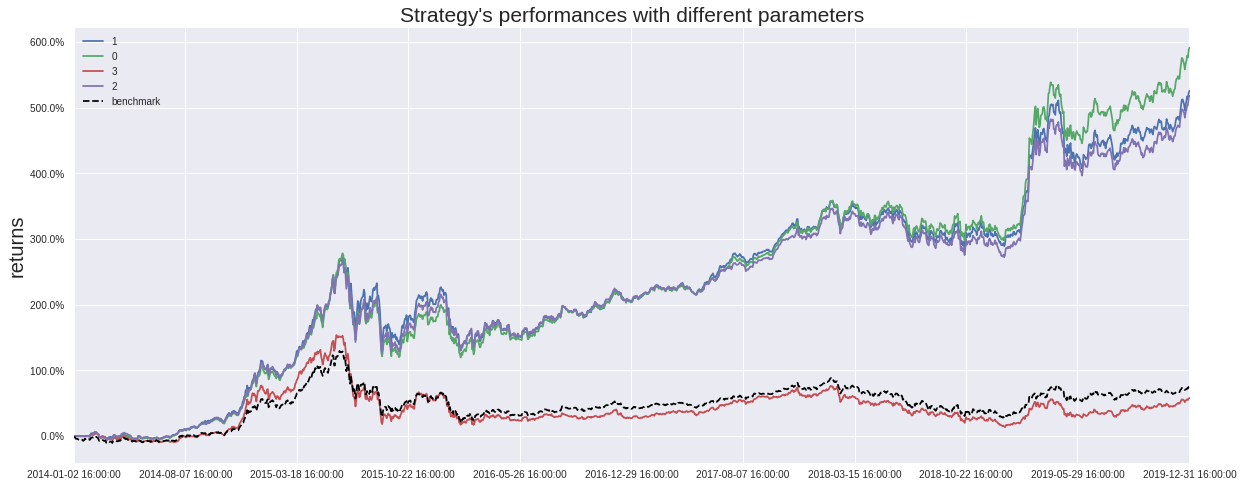

In [21]:
 #7 回报率折线图    
pa.plot_returns()